In [1]:
# !unzip cars.zip

In [2]:
from dataclasses import dataclass
import shutil
from glob import glob
from pathlib import Path
from typing import List, Optional

from PIL import Image
from IPython.display import Image as JImage
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

### helpers

In [3]:
coco_instance_category_names = [
    "__background__",
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "N/A",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "N/A",
    "backpack",
    "umbrella",
    "N/A",
    "N/A",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "N/A",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "N/A",
    "dining table",
    "N/A",
    "N/A",
    "toilet",
    "N/A",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "N/A",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
]

In [4]:
BinaryMask = Frame = np.ndarray


@dataclass
class ObjectMask:
    object_name: str
    mask: BinaryMask



class InstanceSegmentation:
    def __init__(self):
        self.model = self._get_instance_segmentation_model()
        self.device = self._get_device()

    @property
    def gpu(self) -> bool:
        return torch.cuda.is_available()

    def _get_device(self) -> torch.device:
        return torch.device("cuda" if self.gpu else "cpu")

    def _get_instance_segmentation_model(self):
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
        model.eval()
        return model.to(self._get_device())

    def get_instance_segmentation(
        self,
        img_path: Optional[str] = None,
        frame: Optional[Frame] = None,
        threshold: float = 0.5,
    ) -> List[ObjectMask]:
        """
        Takes either a path to an image on disk or a numpy nd-array representing an image.
        Passes it through the model and returns object masks with score >= threshold.
        """
        img = np.array(
            Image.open(img_path)
            if img_path is not None
            else Image.fromarray(frame.astype("uint8"), "RGB")
        )
        img = transforms.ToTensor()(img).unsqueeze(dim=0)
        predictions = self.model(img.to(self.device))[0]
        labels = predictions["labels"]
        scores = predictions["scores"]
        masks = predictions["masks"]
        return [
            ObjectMask(
                object_name=coco_instance_category_names[label.item()],
                mask=(mask >= threshold).squeeze().cpu().detach().numpy().astype(bool),
            )
            for label, score, mask in zip(labels, scores, masks)
            if score.item() >= threshold
        ]

    
def get_mask(path: str) -> Image:
    res = InstanceSegmentation().get_instance_segmentation(img_path=path)
    best = sorted([
        x for x in res
        if x.object_name == 'car'
    ], key=lambda x: x.mask.sum(), reverse=True)
    return Image.fromarray(best[0].mask)


# took from some stackoverflow answer
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

### params

In [5]:
base = 'cars/tesla-model-3-midnight-silver'
locations = ['avana-sunnyvale', 'santa-clara-square-rooftop']

### test

/apps/python3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


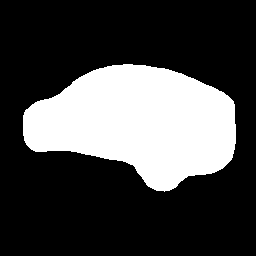

In [6]:
get_mask('cars/tesla-model-3-midnight-silver/avana-sunnyvale/image/IMG_0460.JPEG')

### find images and extract instance segmentations

In [7]:
for loc in locations:
    loc_base = Path(base) / Path(loc)
    paths = glob(str((loc_base / Path("*.JPEG"))))
    
    for p in paths:
        path = Path(p)
        mask = get_mask(p)
        path_new_img = path.parent / Path(f"image/{path.name}")
        path_new_mask = path.parent / Path(f"mask/{path.name}")
        path_new_img.parent.mkdir(exist_ok=True)
        path_new_mask.parent.mkdir(exist_ok=True)
        mask.save(path_new_mask)
        shutil.move(path, path_new_img)

In [8]:
df_paths = pd.DataFrame(
    {'path_img': p}
    for loc in locations
    for p in glob(f'cars/tesla-model-3-midnight-silver/{loc}/image/*')
)
df_paths = df_paths.assign(path_mask=df_paths.path_img.str.replace('/image/', '/mask/', regex=False))

In [9]:
df_paths.sample(10, random_state=0)

,path_img,path_mask
461,cars/tesla-model-3-midnight-silver/avana-sunny...,cars/tesla-model-3-midnight-silver/avana-sunny...
1126,cars/tesla-model-3-midnight-silver/santa-clara...,cars/tesla-model-3-midnight-silver/santa-clara...
34,cars/tesla-model-3-midnight-silver/avana-sunny...,cars/tesla-model-3-midnight-silver/avana-sunny...
491,cars/tesla-model-3-midnight-silver/avana-sunny...,cars/tesla-model-3-midnight-silver/avana-sunny...
9,cars/tesla-model-3-midnight-silver/avana-sunny...,cars/tesla-model-3-midnight-silver/avana-sunny...
982,cars/tesla-model-3-midnight-silver/avana-sunny...,cars/tesla-model-3-midnight-silver/avana-sunny...
425,cars/tesla-model-3-midnight-silver/avana-sunny...,cars/tesla-model-3-midnight-silver/avana-sunny...
1379,cars/tesla-model-3-midnight-silver/santa-clara...,cars/tesla-model-3-midnight-silver/santa-clara...
315,cars/tesla-model-3-midnight-silver/avana-sunny...,cars/tesla-model-3-midnight-silver/avana-sunny...
303,cars/tesla-model-3-midnight-silver/avana-sunny...,cars/tesla-model-3-midnight-silver/avana-sunny...


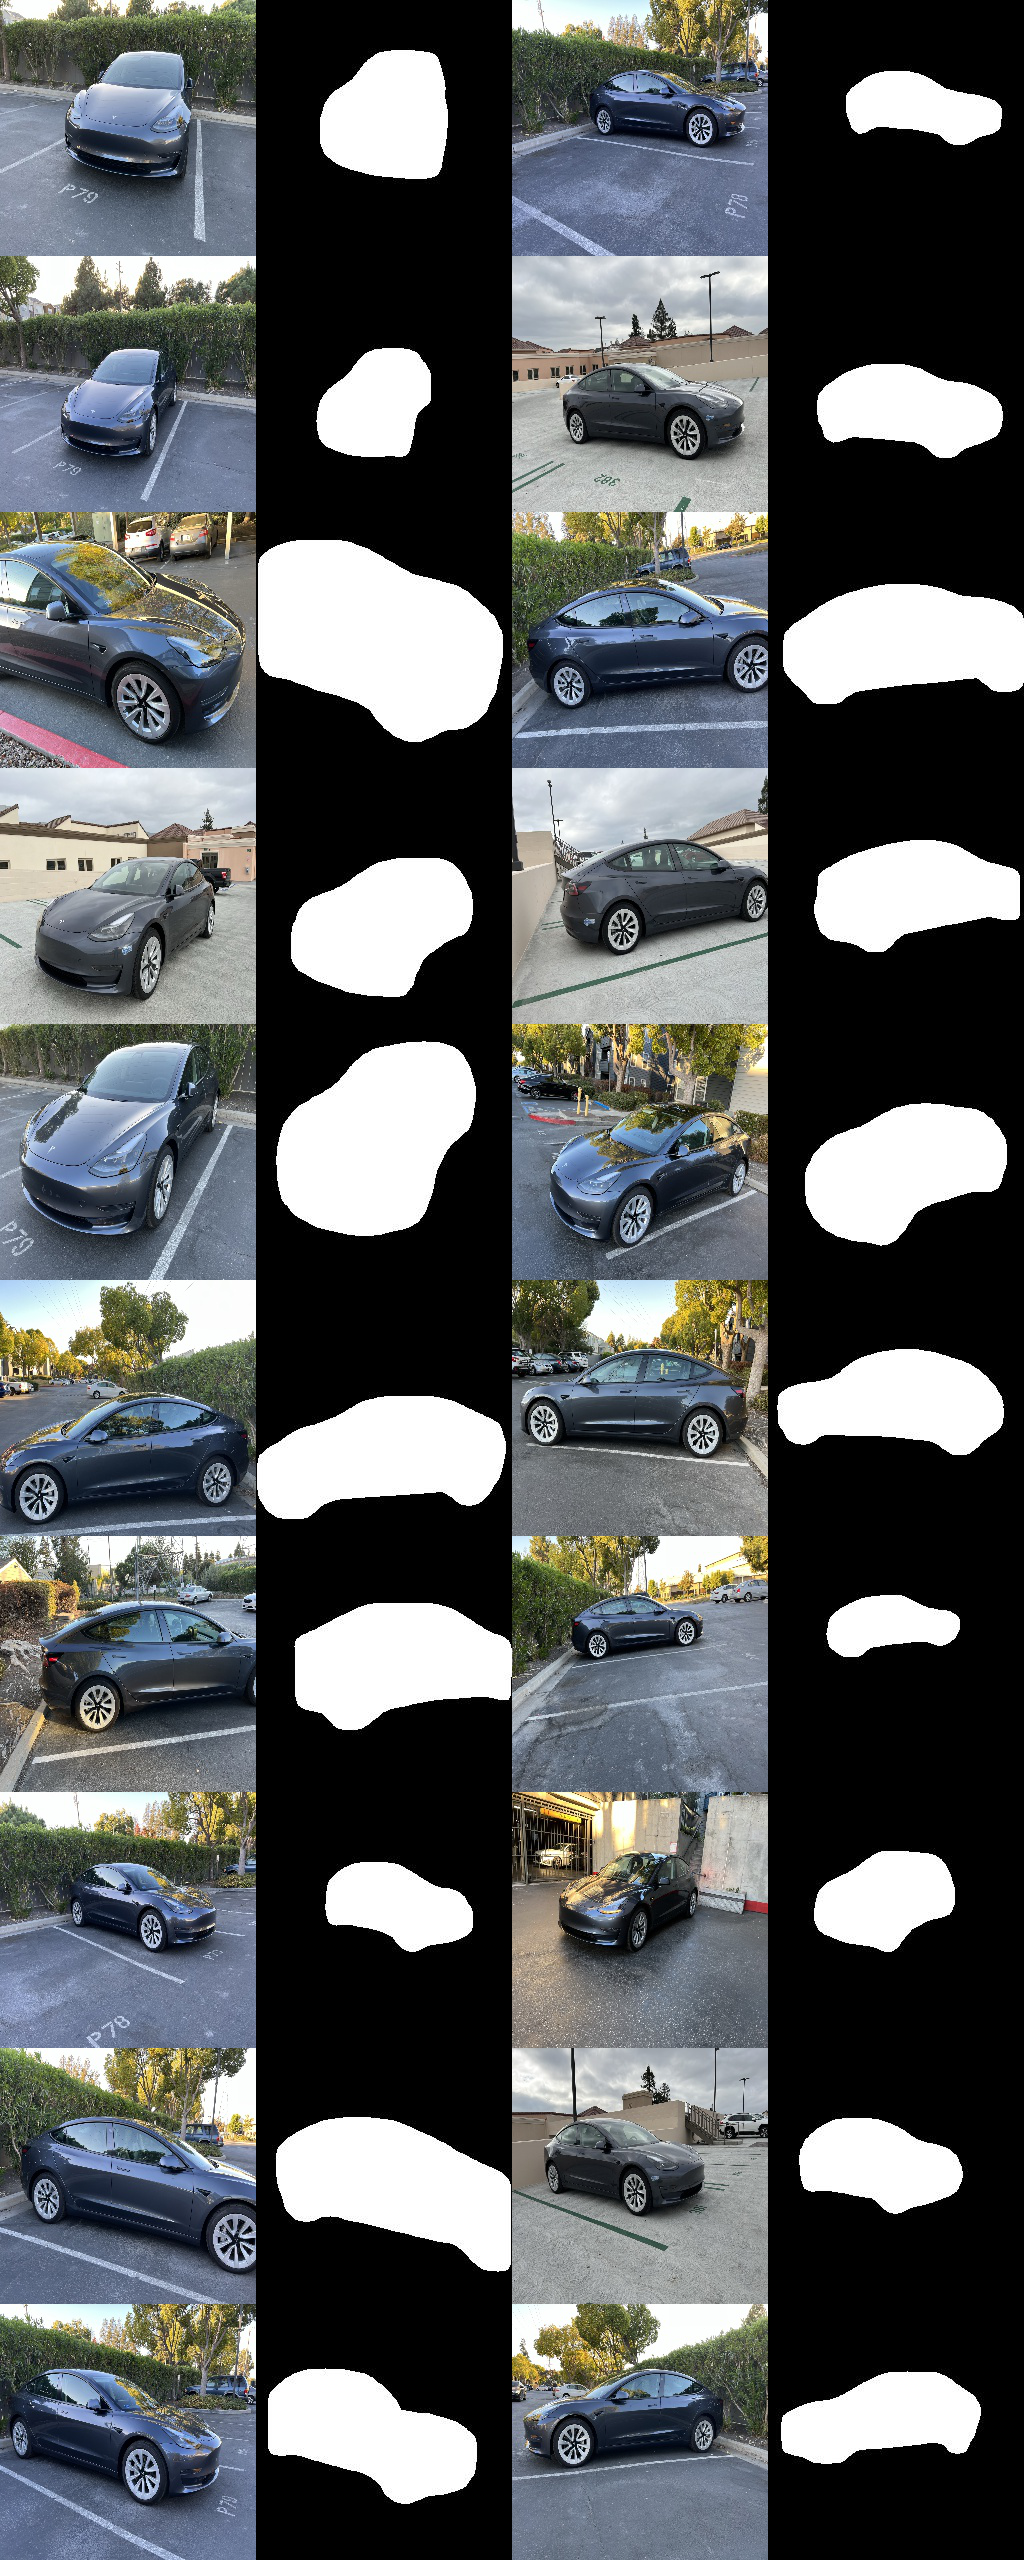

In [15]:
n = 20
pairs = [
    Image.open(x)
    for _, row in df_paths.sample(n, random_state=None).iterrows()
    for x in [row.path_img, row.path_mask]
]
image_grid(pairs, n // 2, 4)